# Plot Points from Streamlit Dashboard

This notebook loads and visualizes data points extracted from the Point Finder Dashboard.

**Supports both CSV and JSON formats**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from PIL import Image

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Points from CSV

CSV format from the dashboard:
```
px_x,px_y,norm_x,norm_y
```

In [14]:
# Load CSV file
csv_file = '../data/origin_points.csv'  # Change this to your downloaded CSV file

df = pd.read_csv(csv_file)
print(f"Loaded {len(df)} points from {csv_file}")
print("\nData preview:")
df.head()

Loaded 5 points from ../data/origin_points.csv

Data preview:


,px_x,px_y,norm_x,norm_y
0,362,296,0.3686,0.3379
1,418,298,0.4257,0.3402
2,475,270,0.4837,0.3082
3,530,385,0.5397,0.4395
4,601,480,0.6120,0.5479


## 2. Load Points from JSON (Alternative)

JSON format includes image metadata and is preferred for downstream work.

In [15]:
# Load JSON file
json_file = '../data/sample_points.json'  # Change this to your downloaded JSON file

with open(json_file, 'r') as f:
    data = json.load(f)

print(f"Image: {data['image_path']}")
print(f"Dimensions: {data['width']} x {data['height']} px")
print(f"Rotation applied: {data['rotate_deg']}°")
print(f"Number of points: {len(data['points_px'])}")

# Convert to DataFrame for easier manipulation
df_json = pd.DataFrame({
    'px_x': [p[0] for p in data['points_px']],
    'px_y': [p[1] for p in data['points_px']],
    'norm_x': [p[0] for p in data['points_norm']],
    'norm_y': [p[1] for p in data['points_norm']]
})

print("\nJSON data as DataFrame:")
df_json.head()

Image: test_image.png
Dimensions: 490 x 1952 px
Rotation applied: 0.0°
Number of points: 7

JSON data as DataFrame:


,px_x,px_y,norm_x,norm_y
0,150.5,200.3,0.3068,0.1026
1,250.8,180.7,0.5115,0.0926
2,350.2,220.4,0.7145,0.1129
3,450.6,190.5,0.9193,0.0976
4,200.3,350.8,0.4085,0.1798


## 3. Basic Plot: Points Only

Simple scatter plot of the extracted points.

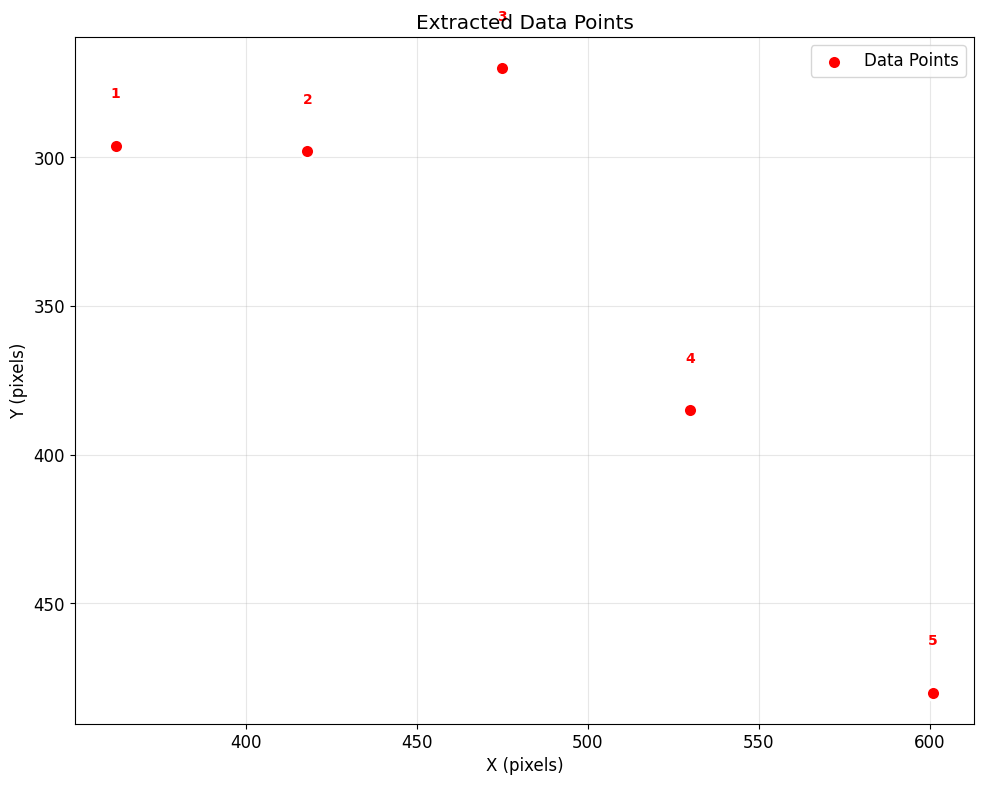

In [16]:
# Use whichever dataframe you loaded (CSV or JSON)
points_df = df  # or df_json

fig, ax = plt.subplots(figsize=(10, 8))

# Plot points
ax.scatter(points_df['px_x'], points_df['px_y'], 
           c='red', s=100, marker='o', 
           edgecolors='white', linewidths=2,
           label='Data Points', zorder=5)

# Add point numbers
for i, row in points_df.iterrows():
    ax.text(row['px_x'], row['px_y'] - 15, str(i+1),
           fontsize=10, color='red', weight='bold',
           ha='center', va='bottom')

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title('Extracted Data Points')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()  # Match image coordinate system (Y increases downward)

plt.tight_layout()
plt.show()

## 4. Plot with Polynomial Fits

Fit polynomials to the points and visualize the curves.

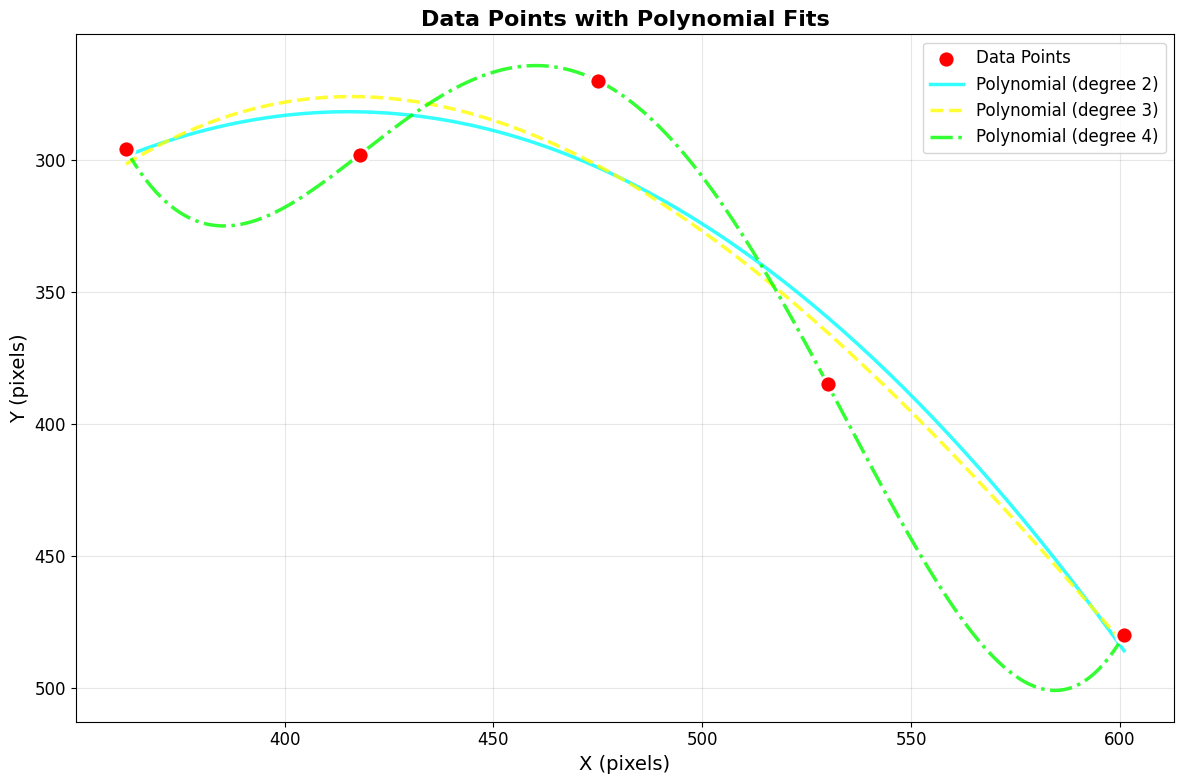

In [17]:
# Sort points by X coordinate for curve fitting
points_sorted = points_df.sort_values('px_x')

x = points_sorted['px_x'].values
y = points_sorted['px_y'].values

fig, ax = plt.subplots(figsize=(12, 8))

# Plot original points
ax.scatter(x, y, c='red', s=150, marker='o', 
           edgecolors='white', linewidths=2,
           label='Data Points', zorder=5)

# Fit and plot polynomials of different degrees
degrees = [2, 3, 4] if len(points_df) >= 5 else [2, 3]
colors = ['cyan', 'yellow', 'lime']
linestyles = ['-', '--', '-.']

x_smooth = np.linspace(x.min(), x.max(), 200)

for degree, color, ls in zip(degrees, colors, linestyles):
    if len(points_df) > degree:
        # Fit polynomial
        coeffs = np.polyfit(x, y, degree)
        poly = np.poly1d(coeffs)
        y_smooth = poly(x_smooth)
        
        # Plot curve
        ax.plot(x_smooth, y_smooth, 
               color=color, linewidth=2.5, 
               linestyle=ls, alpha=0.8,
               label=f'Polynomial (degree {degree})')

ax.set_xlabel('X (pixels)', fontsize=14)
ax.set_ylabel('Y (pixels)', fontsize=14)
ax.set_title('Data Points with Polynomial Fits', fontsize=16, weight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
ax.invert_yaxis()  # Match image coordinate system

plt.tight_layout()
plt.show()

## 5. Overlay on Original Image (Optional)

If you have the original image, you can overlay the points and curves on it.

## 6. Export Polynomial Coefficients

Save the fitted polynomial coefficients for animation or further analysis.

In [18]:
# Fit and save polynomial coefficients
poly_coeffs = {}

for degree in [2, 3, 4, 5]:
    if len(points_df) > degree:
        coeffs = np.polyfit(x, y, degree)
        poly_coeffs[f'degree_{degree}'] = coeffs.tolist()
        
        print(f"\nDegree {degree} polynomial:")
        print(f"  Coefficients: {coeffs}")
        
        # Create polynomial function
        poly = np.poly1d(coeffs)
        print(f"  Function: {poly}")

# Save to JSON for use in other scripts
output_file = 'polynomial_fits.json'
with open(output_file, 'w') as f:
    json.dump(poly_coeffs, f, indent=2)
    
print(f"\n✅ Polynomial coefficients saved to {output_file}")


Degree 2 polynomial:
  Coefficients: [ 5.92500818e-03 -4.92146617e+00  1.30373135e+03]
  Function:           2
0.005925 x - 4.921 x + 1304

Degree 3 polynomial:
  Coefficients: [-1.14512508e-05  2.24744129e-02 -1.27530999e+01  2.51636142e+03]
  Function:             3           2
-1.145e-05 x + 0.02247 x - 12.75 x + 2516

Degree 4 polynomial:
  Coefficients: [-1.35406786e-06  2.58199924e-03 -1.81895580e+00  5.61574580e+02
 -6.38626776e+04]
  Function:             4            3         2
-1.354e-06 x + 0.002582 x - 1.819 x + 561.6 x - 6.386e+04

✅ Polynomial coefficients saved to polynomial_fits.json


## 7. Summary Statistics

In [19]:
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nNumber of points: {len(points_df)}")
print(f"\nX-coordinate range: [{points_df['px_x'].min():.2f}, {points_df['px_x'].max():.2f}]")
print(f"Y-coordinate range: [{points_df['px_y'].min():.2f}, {points_df['px_y'].max():.2f}]")
print(f"\nX-coordinate mean: {points_df['px_x'].mean():.2f} ± {points_df['px_x'].std():.2f}")
print(f"Y-coordinate mean: {points_df['px_y'].mean():.2f} ± {points_df['px_y'].std():.2f}")

if 'data' in locals():
    print(f"\nImage dimensions: {data['width']} x {data['height']} px")
    print(f"Rotation applied: {data['rotate_deg']}°")

SUMMARY STATISTICS

Number of points: 5

X-coordinate range: [362.00, 601.00]
Y-coordinate range: [270.00, 480.00]

X-coordinate mean: 477.20 ± 93.40
Y-coordinate mean: 345.80 ± 86.68

Image dimensions: 490 x 1952 px
Rotation applied: 0.0°


## Next Steps

1. **Replace sample files**: Update `csv_file`, `json_file`, and `image_path` with your actual downloaded files from the Streamlit dashboard
2. **Analyze overfitting**: Use sections 9-10 to understand how different polynomial degrees behave outside the data region
3. **Choose best fit**: Select the polynomial degree that balances fitting accuracy with generalization
4. **Use in Manim**: Import the transformed coordinates and polynomial coefficients from `transformed_coordinates.json` for animation
5. **Further analysis**: Apply other curve fitting methods (splines, exponentials, etc.)

---

## Key Features Added

✨ **Mathematical XY Plane**: Transform pixel coordinates to standard math coordinates with origin at bottom-left  
📊 **Extended Range Plots**: See polynomial behavior beyond data region to identify overfitting  
🔍 **Side-by-Side Comparison**: Compare different polynomial degrees to choose the best fit  
📐 **Normalized Coordinates**: Export to unit square [0,1]×[0,1] for scale-independent work  
💾 **Export for Manim**: All transformed coordinates and polynomial fits saved in JSON format

---

**Happy plotting and animating! 📊✨**

## 8. Transform to Mathematical XY Plane

Convert pixel coordinates to a standard mathematical XY coordinate system with origin at bottom-left.

In [20]:
# Transform pixel coordinates to mathematical XY plane
# Origin at (0, 0), Y increases upward

# Sort points by X for consistency
points_sorted = points_df.sort_values('px_x').reset_index(drop=True)

# Method 1: Simple translation - move minimum point to origin
x_px = points_sorted['px_x'].values
y_px = points_sorted['px_y'].values

# Translate to origin (min_x, max_y becomes (0, 0))
x_translated = x_px - x_px.min()
y_translated = y_px.max() - y_px  # Flip Y axis so it increases upward

# Method 2: Normalize to unit square [0, 1] x [0, 1]
x_range = x_px.max() - x_px.min()
y_range = y_px.max() - y_px.min()

x_normalized = (x_px - x_px.min()) / x_range if x_range > 0 else x_px
y_normalized = (y_px.max() - y_px) / y_range if y_range > 0 else y_px

# Create a DataFrame with transformed coordinates
transformed_df = pd.DataFrame({
    'point': range(1, len(points_sorted) + 1),
    'x_translated': x_translated,
    'y_translated': y_translated,
    'x_normalized': x_normalized,
    'y_normalized': y_normalized,
    'x_original_px': x_px,
    'y_original_px': y_px
})

print("Transformed Coordinates:")
print(transformed_df)
print(f"\nOriginal pixel range: X=[{x_px.min():.2f}, {x_px.max():.2f}], Y=[{y_px.min():.2f}, {y_px.max():.2f}]")
print(f"Translated range: X=[{x_translated.min():.2f}, {x_translated.max():.2f}], Y=[{y_translated.min():.2f}, {y_translated.max():.2f}]")

Transformed Coordinates:
   point  x_translated  y_translated  x_normalized  y_normalized  \
0      1             0           184      0.000000      0.876190   
1      2            56           182      0.234310      0.866667   
2      3           113           210      0.472803      1.000000   
3      4           168            95      0.702929      0.452381   
4      5           239             0      1.000000      0.000000   

   x_original_px  y_original_px  
0            362            296  
1            418            298  
2            475            270  
3            530            385  
4            601            480  

Original pixel range: X=[362.00, 601.00], Y=[270.00, 480.00]
Translated range: X=[0.00, 239.00], Y=[0.00, 210.00]


## 9. Plot on Mathematical XY Plane with Extended Range

Visualize points and polynomial fits with extra whitespace to observe overfitting behavior.

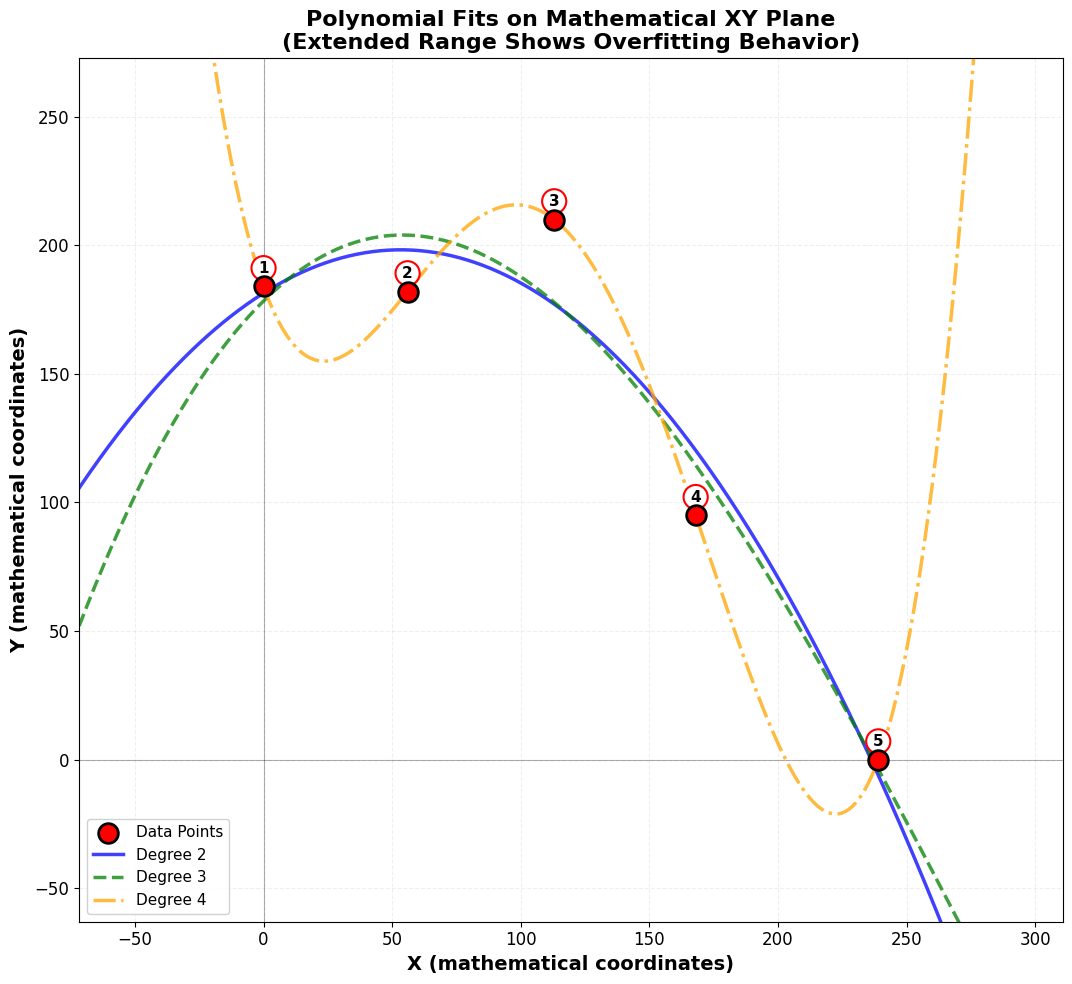


📊 Plot range: X=[-71.70, 310.70], Y=[-63.00, 273.00]
📍 Data range: X=[0.00, 239.00], Y=[0.00, 210.00]


In [21]:
# Use translated coordinates (origin at bottom-left)
x_math = x_translated
y_math = y_translated

# Create extended range for visualization (add 20% padding on each side)
x_data_range = x_math.max() - x_math.min()
y_data_range = y_math.max() - y_math.min()

x_padding = x_data_range * 0.3  # 30% padding
y_padding = y_data_range * 0.3

x_plot_min = x_math.min() - x_padding
x_plot_max = x_math.max() + x_padding
y_plot_min = y_math.min() - y_padding
y_plot_max = y_math.max() + y_padding

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Add grid and axes through origin
ax.axhline(y=0, color='k', linewidth=0.8, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.8, alpha=0.3)
ax.grid(True, alpha=0.2, linestyle='--')

# Plot data points
ax.scatter(x_math, y_math, 
           c='red', s=200, marker='o', 
           edgecolors='black', linewidths=2,
           label='Data Points', zorder=10)

# Add point labels
for i in range(len(x_math)):
    ax.text(x_math[i], y_math[i] + y_data_range*0.02, 
           f'{i+1}',
           fontsize=11, weight='bold',
           ha='center', va='bottom',
           bbox=dict(boxstyle='circle,pad=0.3', 
                    facecolor='white', edgecolor='red', linewidth=1.5))

# Fit and plot polynomials with extended range
degrees_to_fit = [2, 3, 4, 5, 6] if len(x_math) >= 7 else [2, 3, 4, 5]
colors = ['blue', 'green', 'orange', 'purple', 'brown']
linestyles = ['-', '--', '-.', ':', '-']

# Create smooth x values for plotting (within data range)
x_smooth_data = np.linspace(x_math.min(), x_math.max(), 300)

# Create extended x values to show overfitting
x_smooth_extended = np.linspace(x_plot_min, x_plot_max, 500)

for degree, color, ls in zip(degrees_to_fit, colors, linestyles):
    if len(x_math) > degree:
        # Fit polynomial
        coeffs = np.polyfit(x_math, y_math, degree)
        poly = np.poly1d(coeffs)
        
        # Evaluate on extended range
        y_smooth_extended = poly(x_smooth_extended)
        
        # Plot the curve
        ax.plot(x_smooth_extended, y_smooth_extended, 
               color=color, linewidth=2.5, 
               linestyle=ls, alpha=0.75,
               label=f'Degree {degree}')

# Set plot limits with padding
ax.set_xlim(x_plot_min, x_plot_max)
ax.set_ylim(y_plot_min, y_plot_max)

ax.set_xlabel('X (mathematical coordinates)', fontsize=14, weight='bold')
ax.set_ylabel('Y (mathematical coordinates)', fontsize=14, weight='bold')
ax.set_title('Polynomial Fits on Mathematical XY Plane\n(Extended Range Shows Overfitting Behavior)', 
            fontsize=16, weight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)

# Equal aspect ratio for proper visualization
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print(f"\n📊 Plot range: X=[{x_plot_min:.2f}, {x_plot_max:.2f}], Y=[{y_plot_min:.2f}, {y_plot_max:.2f}]")
print(f"📍 Data range: X=[{x_math.min():.2f}, {x_math.max():.2f}], Y=[{y_math.min():.2f}, {y_math.max():.2f}]")

## 10. Compare Polynomial Degrees (Side-by-Side)

Visualize different polynomial degrees separately to better understand overfitting.

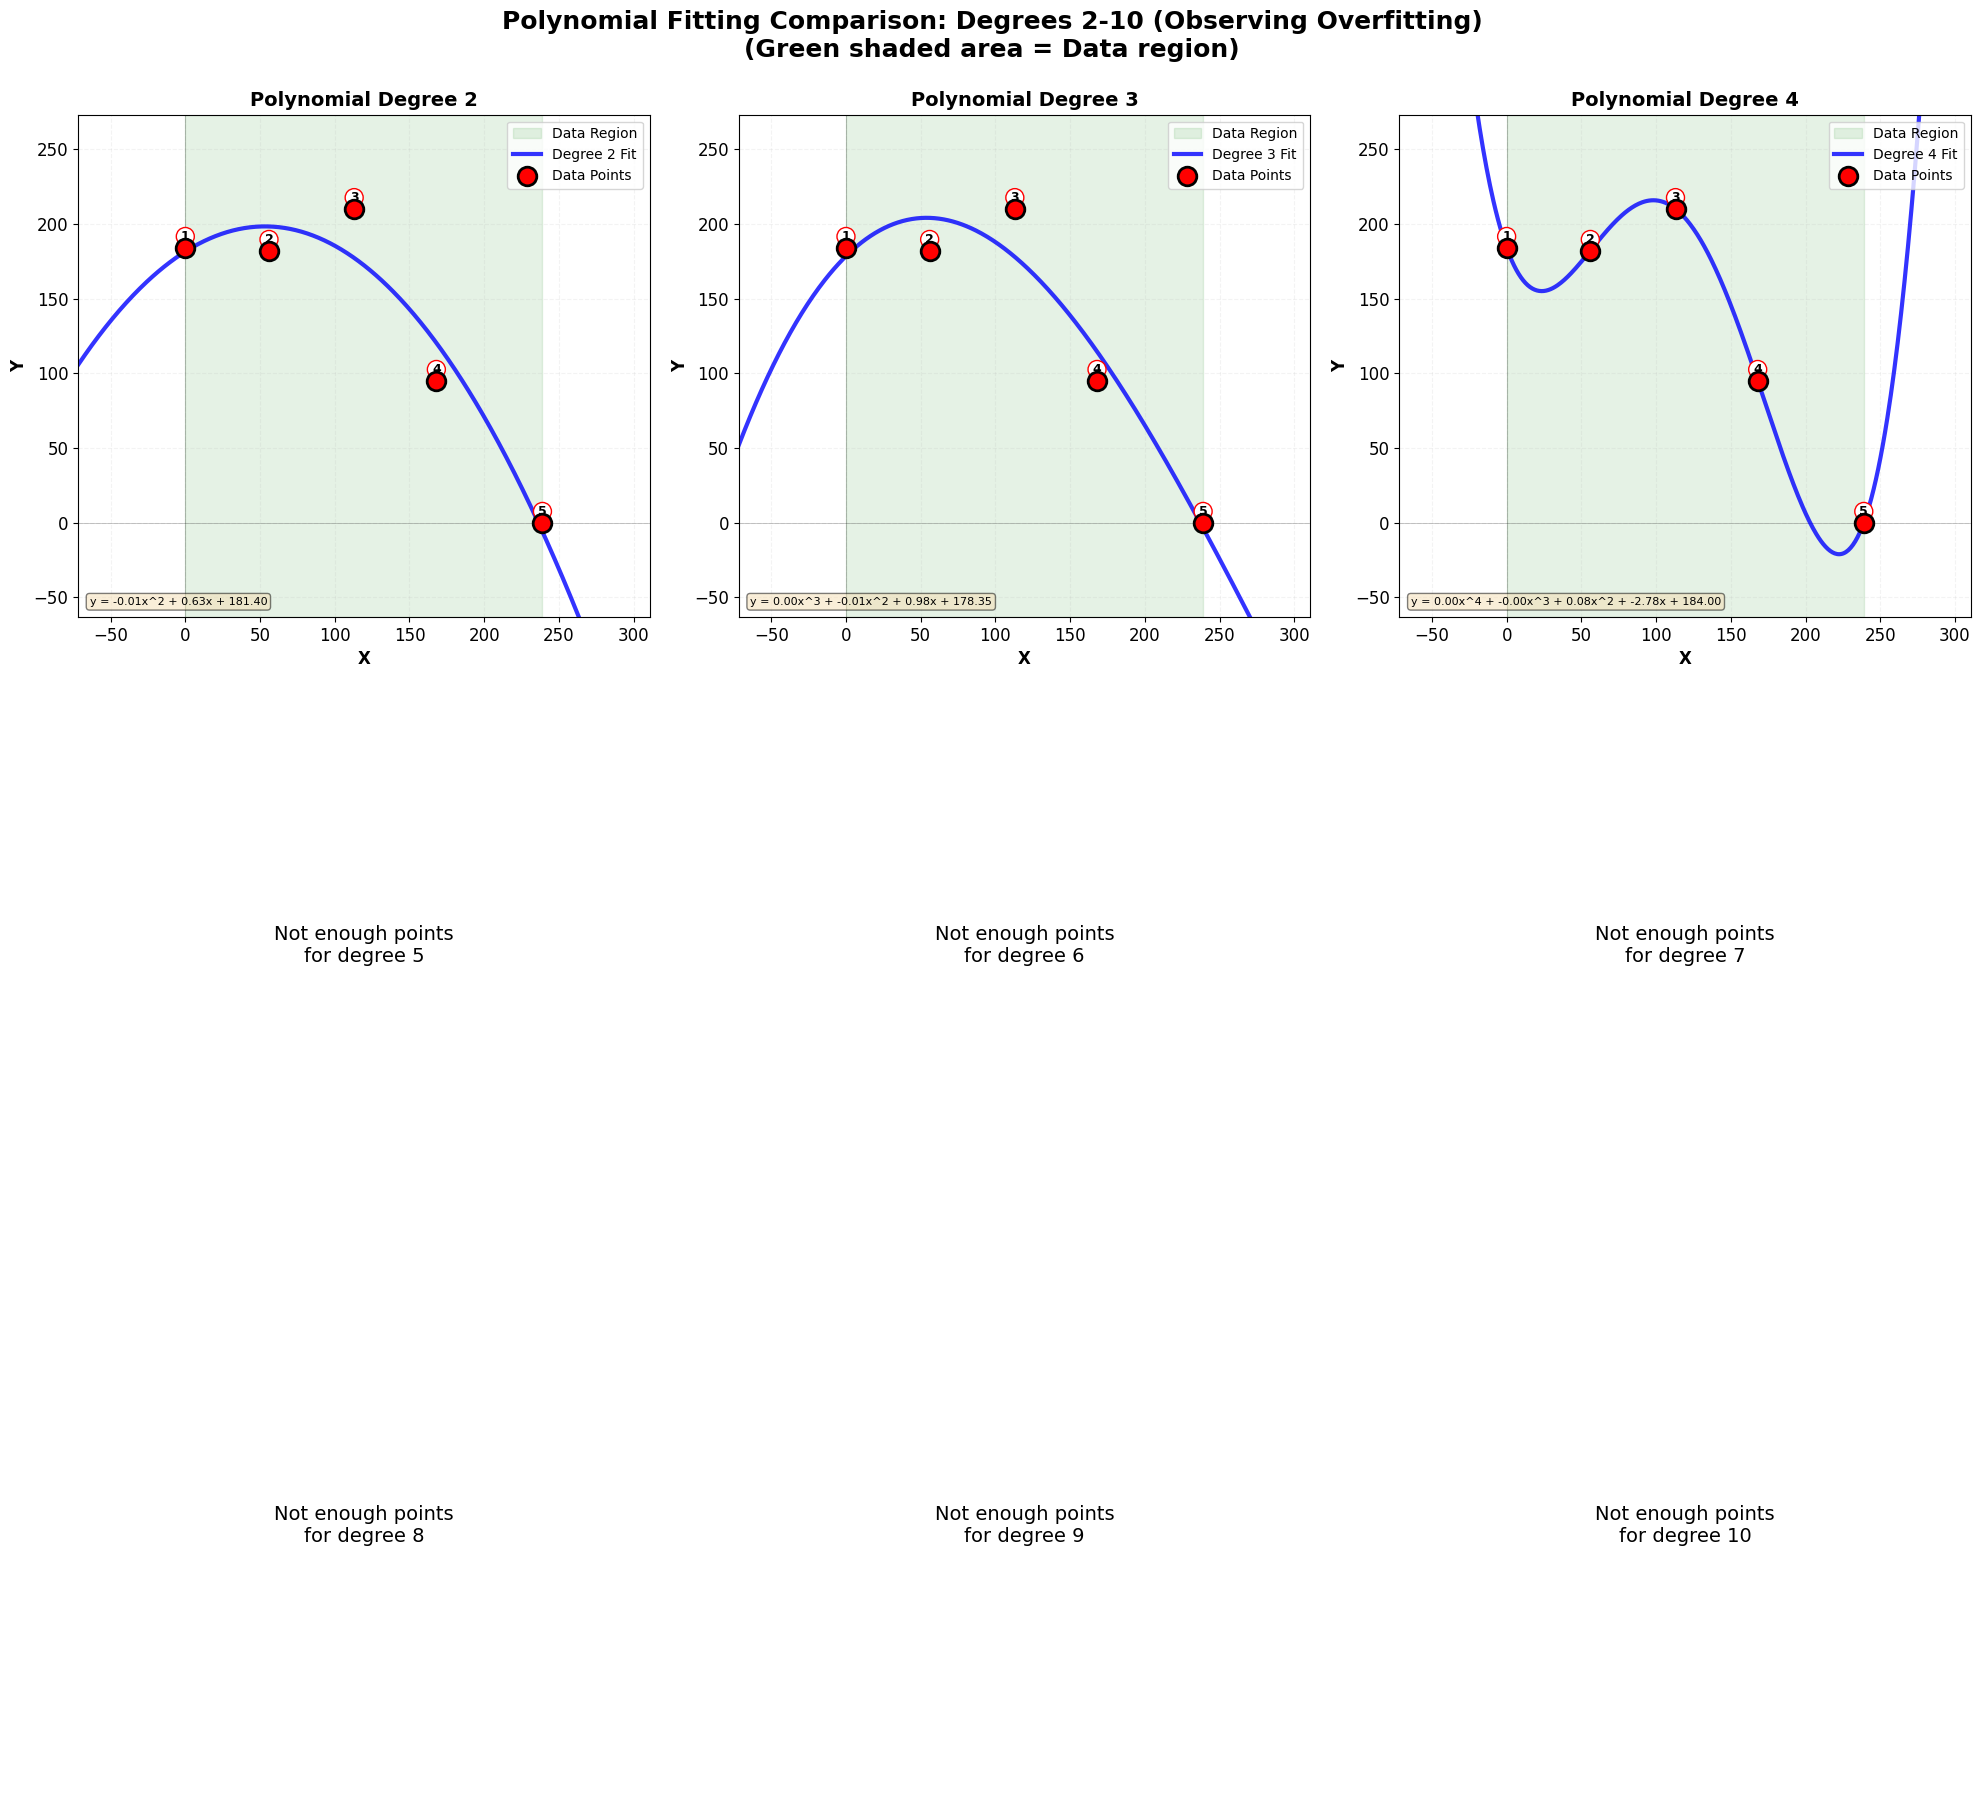


💡 Observation Guide:
  • Lower degrees (2-3): May underfit but generalize better
  • Middle degrees (4-5): Often provide good balance
  • Higher degrees (6-10): Fit data perfectly but may oscillate wildly outside data region
  • Green shaded area shows where we have actual data
  • Watch for wild behavior outside the green region = overfitting!
  • Notice how higher degrees become increasingly unstable at the boundaries!


In [22]:
# Compare different polynomial degrees in subplots
degrees_to_compare = list(range(2, 11))  # Degrees 2 through 10

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, degree in enumerate(degrees_to_compare):
    ax = axes[idx]
    
    if len(x_math) > degree:
        # Fit polynomial
        coeffs = np.polyfit(x_math, y_math, degree)
        poly = np.poly1d(coeffs)
        
        # Evaluate on extended range
        y_smooth = poly(x_smooth_extended)
        
        # Plot
        ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
        ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)
        ax.grid(True, alpha=0.15, linestyle='--')
        
        # Mark the data region
        ax.axvspan(x_math.min(), x_math.max(), alpha=0.1, color='green', 
                   label='Data Region')
        
        # Plot polynomial curve
        ax.plot(x_smooth_extended, y_smooth, 
               color='blue', linewidth=3, alpha=0.8,
               label=f'Degree {degree} Fit')
        
        # Plot data points
        ax.scatter(x_math, y_math, 
                  c='red', s=180, marker='o', 
                  edgecolors='black', linewidths=2,
                  label='Data Points', zorder=10)
        
        # Add point numbers
        for i in range(len(x_math)):
            ax.text(x_math[i], y_math[i] + y_data_range*0.015, 
                   f'{i+1}',
                   fontsize=9, weight='bold',
                   ha='center', va='bottom',
                   bbox=dict(boxstyle='circle,pad=0.2', 
                            facecolor='white', edgecolor='red', linewidth=1))
        
        ax.set_xlim(x_plot_min, x_plot_max)
        ax.set_ylim(y_plot_min, y_plot_max)
        ax.set_xlabel('X', fontsize=12, weight='bold')
        ax.set_ylabel('Y', fontsize=12, weight='bold')
        ax.set_title(f'Polynomial Degree {degree}', fontsize=14, weight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.set_aspect('equal', adjustable='box')
        
        # Add polynomial equation (simplified)
        eq_text = f'y = '
        for i, coef in enumerate(coeffs):
            power = degree - i
            if power == 0:
                eq_text += f'{coef:.2f}'
            elif power == 1:
                eq_text += f'{coef:.2f}x + '
            else:
                eq_text += f'{coef:.2f}x^{power} + '
        
        ax.text(0.02, 0.02, eq_text[:60] + '...' if len(eq_text) > 60 else eq_text,
               transform=ax.transAxes,
               fontsize=8, verticalalignment='bottom',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        ax.text(0.5, 0.5, f'Not enough points\nfor degree {degree}',
               ha='center', va='center', fontsize=14,
               transform=ax.transAxes)
        ax.axis('off')

plt.suptitle('Polynomial Fitting Comparison: Degrees 2-10 (Observing Overfitting)\n(Green shaded area = Data region)', 
            fontsize=18, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Observation Guide:")
print("  • Lower degrees (2-3): May underfit but generalize better")
print("  • Middle degrees (4-5): Often provide good balance")
print("  • Higher degrees (6-10): Fit data perfectly but may oscillate wildly outside data region")
print("  • Green shaded area shows where we have actual data")
print("  • Watch for wild behavior outside the green region = overfitting!")
print("  • Notice how higher degrees become increasingly unstable at the boundaries!")

## 11. Plot on Normalized Unit Square [0, 1] × [0, 1]

Useful for Manim animations and scale-independent analysis.

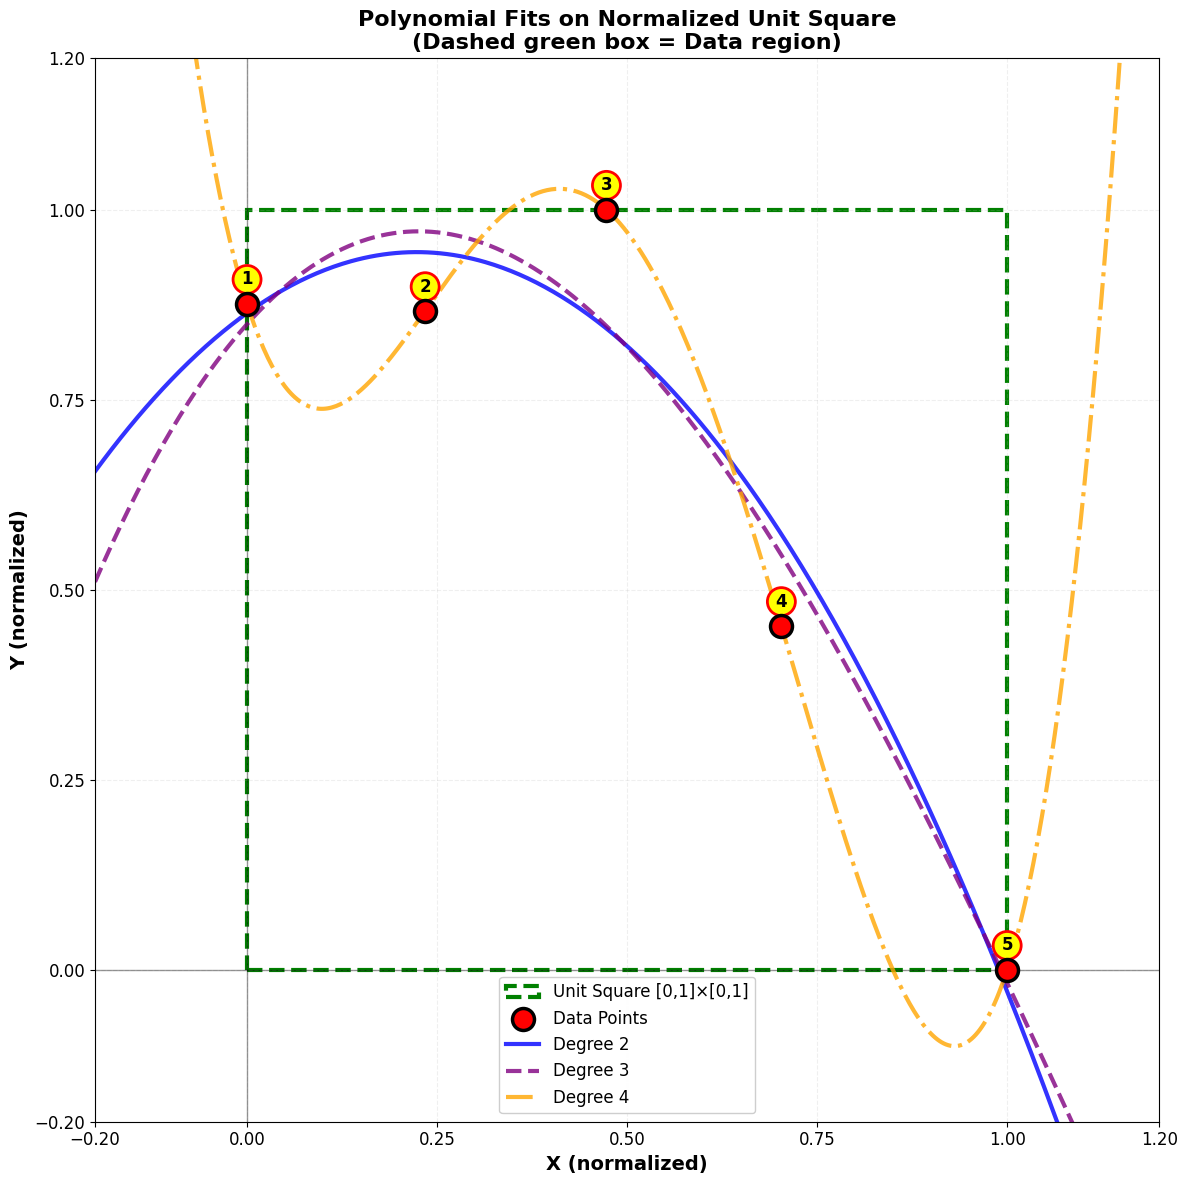


✅ Normalized coordinates ready for Manim or other frameworks!
📐 All data points are within [0, 1] × [0, 1]
🎯 Perfect for scale-independent animations


In [23]:
# Use normalized coordinates [0, 1]
x_norm = x_normalized
y_norm = y_normalized

# Extended range with padding
norm_padding = 0.2  # Extend beyond [0, 1] to show overfitting

x_norm_min = -norm_padding
x_norm_max = 1 + norm_padding
y_norm_min = -norm_padding
y_norm_max = 1 + norm_padding

fig, ax = plt.subplots(figsize=(12, 12))

# Draw unit square boundary
square = plt.Rectangle((0, 0), 1, 1, 
                       fill=False, edgecolor='green', 
                       linewidth=3, linestyle='--',
                       label='Unit Square [0,1]×[0,1]')
ax.add_patch(square)

# Add grid and axes
ax.axhline(y=0, color='k', linewidth=1, alpha=0.4)
ax.axvline(x=0, color='k', linewidth=1, alpha=0.4)
ax.grid(True, alpha=0.2, linestyle='--')

# Plot data points
ax.scatter(x_norm, y_norm, 
           c='red', s=250, marker='o', 
           edgecolors='black', linewidths=2.5,
           label='Data Points', zorder=10)

# Add point labels
for i in range(len(x_norm)):
    ax.text(x_norm[i], y_norm[i] + 0.02, 
           f'{i+1}',
           fontsize=12, weight='bold',
           ha='center', va='bottom',
           bbox=dict(boxstyle='circle,pad=0.3', 
                    facecolor='yellow', edgecolor='red', linewidth=2))

# Fit and plot polynomials
degrees_norm = [2, 3, 4] if len(x_norm) >= 5 else [2, 3]
colors_norm = ['blue', 'purple', 'orange']
linestyles_norm = ['-', '--', '-.']

x_smooth_norm = np.linspace(x_norm_min, x_norm_max, 500)

for degree, color, ls in zip(degrees_norm, colors_norm, linestyles_norm):
    if len(x_norm) > degree:
        # Fit polynomial
        coeffs = np.polyfit(x_norm, y_norm, degree)
        poly = np.poly1d(coeffs)
        y_smooth = poly(x_smooth_norm)
        
        # Plot
        ax.plot(x_smooth_norm, y_smooth, 
               color=color, linewidth=3, 
               linestyle=ls, alpha=0.8,
               label=f'Degree {degree}')

ax.set_xlim(x_norm_min, x_norm_max)
ax.set_ylim(y_norm_min, y_norm_max)
ax.set_xlabel('X (normalized)', fontsize=14, weight='bold')
ax.set_ylabel('Y (normalized)', fontsize=14, weight='bold')
ax.set_title('Polynomial Fits on Normalized Unit Square\n(Dashed green box = Data region)', 
            fontsize=16, weight='bold')
ax.legend(loc='best', fontsize=12, framealpha=0.95)
ax.set_aspect('equal', adjustable='box')

# Add tick marks at key positions
ax.set_xticks([-0.2, 0, 0.25, 0.5, 0.75, 1.0, 1.2])
ax.set_yticks([-0.2, 0, 0.25, 0.5, 0.75, 1.0, 1.2])

plt.tight_layout()
plt.show()

print("\n✅ Normalized coordinates ready for Manim or other frameworks!")
print(f"📐 All data points are within [0, 1] × [0, 1]")
print(f"🎯 Perfect for scale-independent animations")

## 12. Export Transformed Coordinates for Manim

Save the transformed coordinates in formats ready for Manim animation.

In [24]:
# Export transformed coordinates and polynomial fits
export_data = {
    "metadata": {
        "original_image": data.get('image_path', 'unknown') if 'data' in locals() else csv_file,
        "num_points": len(x_math),
        "coordinate_systems": ["translated", "normalized"]
    },
    "points_translated": {
        "x": x_translated.tolist(),
        "y": y_translated.tolist(),
        "range": {
            "x_min": float(x_translated.min()),
            "x_max": float(x_translated.max()),
            "y_min": float(y_translated.min()),
            "y_max": float(y_translated.max())
        }
    },
    "points_normalized": {
        "x": x_normalized.tolist(),
        "y": y_normalized.tolist(),
        "range": {"x_min": 0.0, "x_max": 1.0, "y_min": 0.0, "y_max": 1.0}
    },
    "polynomial_fits": {}
}

# Add polynomial coefficients for both coordinate systems
for degree in [2, 3, 4, 5]:
    if len(x_math) > degree:
        # Translated coordinates
        coeffs_trans = np.polyfit(x_translated, y_translated, degree)
        # Normalized coordinates
        coeffs_norm = np.polyfit(x_normalized, y_normalized, degree)
        
        export_data["polynomial_fits"][f"degree_{degree}"] = {
            "translated_coeffs": coeffs_trans.tolist(),
            "normalized_coeffs": coeffs_norm.tolist()
        }

# Save to JSON
output_json = 'transformed_coordinates.json'
with open(output_json, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✅ Transformed coordinates saved to: {output_json}")

# Also save as CSV for easy inspection
transformed_csv = pd.DataFrame({
    'point': range(1, len(x_math) + 1),
    'x_translated': x_translated,
    'y_translated': y_translated,
    'x_normalized': x_normalized,
    'y_normalized': y_normalized
})

output_csv = 'transformed_coordinates.csv'
transformed_csv.to_csv(output_csv, index=False)
print(f"✅ Transformed coordinates saved to: {output_csv}")

print("\n" + "="*60)
print("COORDINATE TRANSFORMATION SUMMARY")
print("="*60)
print(f"\n1. TRANSLATED COORDINATES (Origin at bottom-left)")
print(f"   Range: X=[{x_translated.min():.2f}, {x_translated.max():.2f}]")
print(f"          Y=[{y_translated.min():.2f}, {y_translated.max():.2f}]")
print(f"\n2. NORMALIZED COORDINATES (Unit square)")
print(f"   Range: X=[0.00, 1.00], Y=[0.00, 1.00]")
print(f"\n3. POLYNOMIAL FITS")
for degree in [2, 3, 4, 5]:
    if f"degree_{degree}" in export_data["polynomial_fits"]:
        print(f"   ✓ Degree {degree} polynomial fitted")
print("\n" + "="*60)

✅ Transformed coordinates saved to: transformed_coordinates.json
✅ Transformed coordinates saved to: transformed_coordinates.csv

COORDINATE TRANSFORMATION SUMMARY

1. TRANSLATED COORDINATES (Origin at bottom-left)
   Range: X=[0.00, 239.00]
          Y=[0.00, 210.00]

2. NORMALIZED COORDINATES (Unit square)
   Range: X=[0.00, 1.00], Y=[0.00, 1.00]

3. POLYNOMIAL FITS
   ✓ Degree 2 polynomial fitted
   ✓ Degree 3 polynomial fitted
   ✓ Degree 4 polynomial fitted

